In [1]:
import torch

# Set the default GPU device to 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [26]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
# import torchaudio
import torch.optim as optim

In [27]:


# Path to the dataset root
DATASET_ROOT = Path("ESC-50-master")

# Path to metadata file
CSV_PATH = DATASET_ROOT / "meta" / "esc50.csv"

# Load the CSV
df = pd.read_csv(CSV_PATH)

# Filter to include only ESC-10 subset
esc10_df = df[df['esc10'] == True]

# Split based on folds
train_df = esc10_df[esc10_df['fold'].isin([1, 2, 3])]
val_df = esc10_df[esc10_df['fold'] == 4]
test_df = esc10_df[esc10_df['fold'] == 5]

# Helper function to get file paths and labels
def get_paths_and_labels(df_subset):
    file_paths = [DATASET_ROOT / "audio" / file for file in df_subset['filename']]
    labels = df_subset['category'].tolist()
    return file_paths, labels

# Get paths and labels
train_files, train_labels = get_paths_and_labels(train_df)
val_files, val_labels = get_paths_and_labels(val_df)
test_files, test_labels = get_paths_and_labels(test_df)


In [28]:
len(train_files)

240

In [29]:


def precompute_melspectrograms(file_paths, labels, save_dir, label_to_idx, n_mels=128, max_frames=500):
    os.makedirs(save_dir, exist_ok=True)
    data = []

    for i, path in tqdm(enumerate(file_paths), total=len(file_paths)):
        y, sr = librosa.load(path, sr=None)
        
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=220)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Crop or pad
        if mel_db.shape[1] < max_frames:
            pad_width = max_frames - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :max_frames]

        # Normalize
        mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-6)

        # Save as .npy
        filename = f"{i:05d}.npy"
        np.save(os.path.join(save_dir, filename), mel_db)

        # Record label
        data.append((filename, label_to_idx[labels[i]]))

    # Save metadata (mapping from filename to label)
    with open(os.path.join(save_dir, 'metadata.pkl'), 'wb') as f:
        pickle.dump(data, f)


In [30]:

# # Label encoding
all_labels = sorted(set(train_labels + val_labels + test_labels))
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
# Dataset class
class ESC10Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        with open(os.path.join(data_dir, 'metadata.pkl'), 'rb') as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, label = self.data[idx]
        mel = np.load(os.path.join(self.data_dir, filename))
        mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 128, 500]
        return mel_tensor, label
# Precompute and save to disk
precompute_melspectrograms(train_files, train_labels, "precomputed/train", label_to_idx)
precompute_melspectrograms(val_files, val_labels, "precomputed/val", label_to_idx)
precompute_melspectrograms(test_files, test_labels, "precomputed/test", label_to_idx)

# Load precomputed dataset
train_dataset = ESC10Dataset("precomputed/train")
val_dataset = ESC10Dataset("precomputed/val")
test_dataset = ESC10Dataset("precomputed/test")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



100%|██████████| 80/80 [00:08<00:00,  9.75it/s]


In [31]:
import matplotlib.pyplot as plt
train_files[0]
audio, sr = librosa.load(train_files[3])


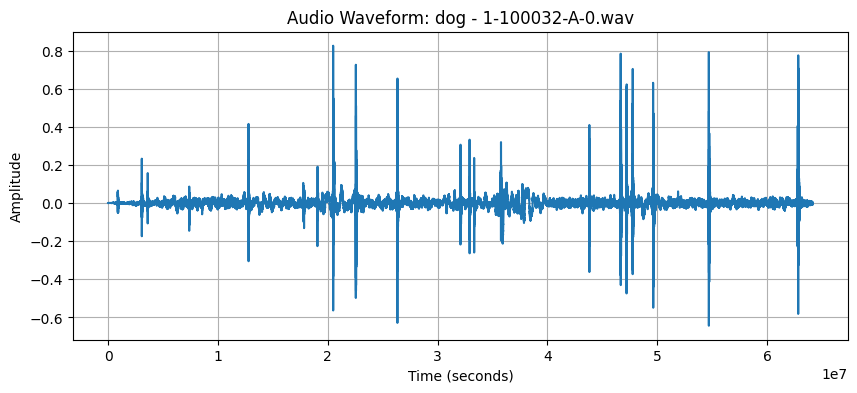

In [8]:
# Plot the waveform with proper time axis
waveform = audio
sample_rate = audio[1]
time = torch.arange(0, len(waveform)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(time, waveform)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Audio Waveform: {train_labels[0]} - {train_files[0].name}')
plt.grid(True)

In [32]:

def train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, 
    epochs=20, device='cpu', 
    save_path='best_model.pth'
):
    model = model.to(device)
    best_val_acc = 0.0

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_bar = tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Training", leave=False)
        for X, y in train_bar:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
            running_loss += loss.item() * y.size(0)

            train_bar.set_postfix(loss=loss.item())

        train_acc = correct / total
        train_loss = running_loss / total
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss_total, correct, total = 0.0, 0, 0

        val_bar = tqdm(val_loader, desc=f"[Epoch {epoch}/{epochs}] Validation", leave=False)
        with torch.no_grad():
            for X, y in val_bar:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                _, predicted = outputs.max(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)
                val_loss_total += loss.item() * y.size(0)

        val_acc = correct / total
        val_loss = val_loss_total / total
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        tqdm.write(
            f"Epoch {epoch}/{epochs} | "
            f"Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}, Loss: {val_loss:.4f}"
        )

    return train_accs, val_accs, train_losses, val_losses


In [33]:

def plot(train_accs, val_accs, train_losses=None, val_losses=None):
    epochs = range(1, len(train_accs) + 1)
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot (only if provided)
    if train_losses is not None and val_losses is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Final Evaluation] Test Accuracy: {acc:.4f}")
    return acc


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [35]:

class ESC10CNN(nn.Module):
    def __init__(self, norm_type=None, output_dim=10):
        super(ESC10CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)   # -> (16, 128, 500)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # -> (32, 128, 500)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)                   # -> (32, 14, 55)

        self.flattened_size = 32 * 14 * 55  # = 24640

        self.norm_type = norm_type
        if norm_type == 'layer':
            self.norm = nn.LayerNorm(self.flattened_size)
        elif norm_type == 'batch':
            self.norm = nn.BatchNorm1d(self.flattened_size)
        else:
            self.norm = None

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, H, W]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 16, H/3, W/3]
        x = x.view(x.size(0), -1)             # flatten

        if self.norm:
            x = self.norm(x)  # apply layer or batch norm

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)
  

In [36]:
import random
random.seed(42)

Epoch 1/20 | Train Acc: 0.1708, Loss: 2.2762 | Val Acc: 0.2375, Loss: 1.9651


Epoch 2/20 | Train Acc: 0.4958, Loss: 1.4691 | Val Acc: 0.4000, Loss: 1.6042


Epoch 3/20 | Train Acc: 0.6125, Loss: 0.9734 | Val Acc: 0.5750, Loss: 1.2566


Epoch 4/20 | Train Acc: 0.7417, Loss: 0.6773 | Val Acc: 0.5625, Loss: 1.1827


Epoch 5/20 | Train Acc: 0.8083, Loss: 0.5169 | Val Acc: 0.6375, Loss: 1.1584


Epoch 6/20 | Train Acc: 0.8792, Loss: 0.3453 | Val Acc: 0.6375, Loss: 1.2074


Epoch 7/20 | Train Acc: 0.9167, Loss: 0.2668 | Val Acc: 0.6000, Loss: 1.3302


Epoch 8/20 | Train Acc: 0.9417, Loss: 0.1867 | Val Acc: 0.6875, Loss: 1.1776


Epoch 9/20 | Train Acc: 0.9542, Loss: 0.1357 | Val Acc: 0.6375, Loss: 1.4731


Epoch 10/20 | Train Acc: 0.9250, Loss: 0.1914 | Val Acc: 0.6375, Loss: 1.7016


Epoch 11/20 | Train Acc: 0.9375, Loss: 0.2164 | Val Acc: 0.6000, Loss: 1.4133


Epoch 12/20 | Train Acc: 0.9375, Loss: 0.1770 | Val Acc: 0.7125, Loss: 1.1229


Epoch 13/20 | Train Acc: 0.9667, Loss: 0.0883 | Val Acc: 0.7250, Loss: 1.1399


Epoch 14/20 | Train Acc: 0.9875, Loss: 0.0748 | Val Acc: 0.6375, Loss: 1.3832


Epoch 15/20 | Train Acc: 0.9875, Loss: 0.0383 | Val Acc: 0.6500, Loss: 1.2682


Epoch 16/20 | Train Acc: 0.9958, Loss: 0.0194 | Val Acc: 0.6750, Loss: 1.3807


Epoch 17/20 | Train Acc: 1.0000, Loss: 0.0114 | Val Acc: 0.6875, Loss: 1.2707


Epoch 18/20 | Train Acc: 1.0000, Loss: 0.0071 | Val Acc: 0.6500, Loss: 1.4549


Epoch 19/20 | Train Acc: 1.0000, Loss: 0.0054 | Val Acc: 0.6875, Loss: 1.4308


Epoch 20/20 | Train Acc: 1.0000, Loss: 0.0039 | Val Acc: 0.6750, Loss: 1.4432


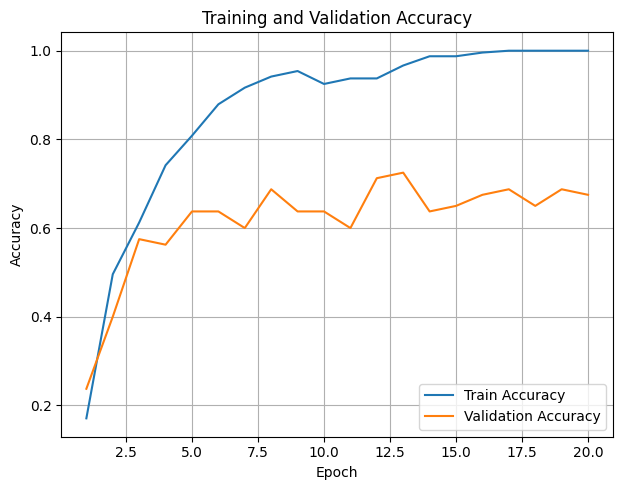

/tmp/ipykernel_1384480/1008257851.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [37]:


model = ESC10CNN()
# model = torch.nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_accs, val_accs, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    epochs=20,
    device=device,  # use GPU
    save_path='best_model.pth'
)


# Plot training vs validation accuracy
plot(train_accs, val_accs)

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))



In [38]:
evaluate_model(model, test_loader)

[Final Evaluation] Test Accuracy: 0.7000


0.7

In [39]:

def run_training(optimizer_name, model_cls, train_loader, val_loader, test_loader, device):
    model = model_cls().to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'SGD+Momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Unknown optimizer")

    print(f"Training with {optimizer_name}...")
    train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=20,
        device=device,
        save_path=f'model_{optimizer_name}.pth'
    )

    # Load best model
    model.load_state_dict(torch.load(f'model_{optimizer_name}.pth'))

    # Evaluate on test set
    test_acc = evaluate_model(model, test_loader, device=device, verbose=False)
    
    return {
        "optimizer": optimizer_name,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_acc": test_acc
    }
def evaluate_model(model, test_loader, device='cpu', verbose=True):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if verbose:
        print(f"Test Accuracy: {acc:.4f}")
    return acc


In [40]:

def plot_all_results(results):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for res in results:
        epochs = range(1, len(res['train_accs']) + 1)
        plt.plot(epochs, res['train_accs'], label=f"{res['optimizer']} Train")
        plt.plot(epochs, res['val_accs'], '--', label=f"{res['optimizer']} Val")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    for res in results:
        epochs = range(1, len(res['train_losses']) + 1)
        plt.plot(epochs, res['train_losses'], label=f"{res['optimizer']} Train")
        plt.plot(epochs, res['val_losses'], '--', label=f"{res['optimizer']} Val")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Optimizer Comparison (3a)

Training with SGD...


Epoch 1/20 | Train Acc: 0.1500, Loss: 2.2925 | Val Acc: 0.3250, Loss: 2.2709


Epoch 2/20 | Train Acc: 0.2417, Loss: 2.2476 | Val Acc: 0.2875, Loss: 2.2159


Epoch 3/20 | Train Acc: 0.2208, Loss: 2.1702 | Val Acc: 0.2375, Loss: 2.1179


Epoch 4/20 | Train Acc: 0.2708, Loss: 2.0384 | Val Acc: 0.2625, Loss: 1.9697


Epoch 5/20 | Train Acc: 0.3333, Loss: 1.8424 | Val Acc: 0.3750, Loss: 1.8058


Epoch 6/20 | Train Acc: 0.4042, Loss: 1.6750 | Val Acc: 0.3500, Loss: 1.7050


Epoch 7/20 | Train Acc: 0.4167, Loss: 1.5732 | Val Acc: 0.2500, Loss: 1.7323


Epoch 8/20 | Train Acc: 0.4708, Loss: 1.4389 | Val Acc: 0.4000, Loss: 1.6671


Epoch 9/20 | Train Acc: 0.5042, Loss: 1.3756 | Val Acc: 0.4000, Loss: 1.6222


Epoch 10/20 | Train Acc: 0.5333, Loss: 1.1980 | Val Acc: 0.4500, Loss: 1.7733


Epoch 11/20 | Train Acc: 0.5458, Loss: 1.1835 | Val Acc: 0.4500, Loss: 1.5421


Epoch 12/20 | Train Acc: 0.5667, Loss: 1.0927 | Val Acc: 0.4000, Loss: 1.5993


Epoch 13/20 | Train Acc: 0.5917, Loss: 1.1433 | Val Acc: 0.4875, Loss: 1.5619


Epoch 14/20 | Train Acc: 0.6333, Loss: 0.9588 | Val Acc: 0.5000, Loss: 1.4005


Epoch 15/20 | Train Acc: 0.6625, Loss: 0.8956 | Val Acc: 0.5000, Loss: 1.3666


Epoch 16/20 | Train Acc: 0.6458, Loss: 0.8160 | Val Acc: 0.4625, Loss: 1.4182


Epoch 17/20 | Train Acc: 0.7333, Loss: 0.7324 | Val Acc: 0.5375, Loss: 1.4242


Epoch 18/20 | Train Acc: 0.7125, Loss: 0.7908 | Val Acc: 0.5000, Loss: 1.3627


Epoch 19/20 | Train Acc: 0.7583, Loss: 0.6646 | Val Acc: 0.5000, Loss: 1.4269


/tmp/ipykernel_1384480/3191131198.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{optimizer_name}.pth'))


Epoch 20/20 | Train Acc: 0.8125, Loss: 0.5575 | Val Acc: 0.6375, Loss: 1.2995
Training with SGD+Momentum...


Epoch 1/20 | Train Acc: 0.1250, Loss: 2.2982 | Val Acc: 0.3000, Loss: 2.2680


Epoch 2/20 | Train Acc: 0.3458, Loss: 2.1609 | Val Acc: 0.2625, Loss: 1.9761


Epoch 3/20 | Train Acc: 0.3875, Loss: 1.7744 | Val Acc: 0.3250, Loss: 1.7620


Epoch 4/20 | Train Acc: 0.4542, Loss: 1.4847 | Val Acc: 0.4375, Loss: 1.7313


Epoch 5/20 | Train Acc: 0.5458, Loss: 1.1693 | Val Acc: 0.5500, Loss: 1.5596


Epoch 6/20 | Train Acc: 0.6750, Loss: 0.8450 | Val Acc: 0.4500, Loss: 1.5477


Epoch 7/20 | Train Acc: 0.6542, Loss: 0.9388 | Val Acc: 0.5125, Loss: 1.4014


Epoch 8/20 | Train Acc: 0.7417, Loss: 0.6872 | Val Acc: 0.5375, Loss: 1.6795


Epoch 9/20 | Train Acc: 0.6917, Loss: 0.9849 | Val Acc: 0.4500, Loss: 1.5942


Epoch 10/20 | Train Acc: 0.6542, Loss: 0.8803 | Val Acc: 0.4750, Loss: 1.6326


Epoch 11/20 | Train Acc: 0.8042, Loss: 0.4765 | Val Acc: 0.6000, Loss: 1.6139


Epoch 12/20 | Train Acc: 0.8583, Loss: 0.4540 | Val Acc: 0.7500, Loss: 1.0299


Epoch 13/20 | Train Acc: 0.8708, Loss: 0.3520 | Val Acc: 0.7250, Loss: 1.1197


Epoch 14/20 | Train Acc: 0.8917, Loss: 0.3090 | Val Acc: 0.6000, Loss: 1.6806


Epoch 15/20 | Train Acc: 0.8875, Loss: 0.2940 | Val Acc: 0.5500, Loss: 1.8869


Epoch 16/20 | Train Acc: 0.9042, Loss: 0.3197 | Val Acc: 0.6750, Loss: 1.5727


Epoch 17/20 | Train Acc: 0.9000, Loss: 0.2606 | Val Acc: 0.7000, Loss: 1.4134


Epoch 18/20 | Train Acc: 0.9375, Loss: 0.1915 | Val Acc: 0.7125, Loss: 1.6095


Epoch 19/20 | Train Acc: 0.9208, Loss: 0.1781 | Val Acc: 0.7000, Loss: 1.3784


Epoch 20/20 | Train Acc: 0.9083, Loss: 0.2744 | Val Acc: 0.5625, Loss: 2.1464
Training with RMSprop...


Epoch 1/20 | Train Acc: 0.1167, Loss: 4.9828 | Val Acc: 0.2875, Loss: 2.1309


Epoch 2/20 | Train Acc: 0.3583, Loss: 1.7699 | Val Acc: 0.3375, Loss: 1.5219


Epoch 3/20 | Train Acc: 0.5000, Loss: 1.2976 | Val Acc: 0.4125, Loss: 1.6311


Epoch 4/20 | Train Acc: 0.6458, Loss: 0.9600 | Val Acc: 0.6250, Loss: 1.0842


Epoch 5/20 | Train Acc: 0.7125, Loss: 0.7401 | Val Acc: 0.6500, Loss: 1.0311


Epoch 6/20 | Train Acc: 0.7958, Loss: 0.5656 | Val Acc: 0.6500, Loss: 1.0793


Epoch 7/20 | Train Acc: 0.8292, Loss: 0.4717 | Val Acc: 0.5625, Loss: 1.2952


Epoch 8/20 | Train Acc: 0.8625, Loss: 0.3786 | Val Acc: 0.6750, Loss: 1.1353


Epoch 9/20 | Train Acc: 0.8958, Loss: 0.3657 | Val Acc: 0.7375, Loss: 1.0383


Epoch 10/20 | Train Acc: 0.9250, Loss: 0.2328 | Val Acc: 0.6625, Loss: 1.2662


Epoch 11/20 | Train Acc: 0.9250, Loss: 0.2402 | Val Acc: 0.7000, Loss: 1.0092


Epoch 12/20 | Train Acc: 0.9625, Loss: 0.1524 | Val Acc: 0.7000, Loss: 1.1450


Epoch 13/20 | Train Acc: 0.9125, Loss: 0.2098 | Val Acc: 0.5375, Loss: 1.6659


Epoch 14/20 | Train Acc: 0.9583, Loss: 0.1513 | Val Acc: 0.6500, Loss: 2.0078


Epoch 15/20 | Train Acc: 0.9375, Loss: 0.2220 | Val Acc: 0.7000, Loss: 1.0344


Epoch 16/20 | Train Acc: 0.9500, Loss: 0.1529 | Val Acc: 0.7250, Loss: 1.0918


Epoch 17/20 | Train Acc: 0.9833, Loss: 0.0671 | Val Acc: 0.7000, Loss: 1.2243


Epoch 18/20 | Train Acc: 0.9750, Loss: 0.0734 | Val Acc: 0.6750, Loss: 1.3587


Epoch 19/20 | Train Acc: 0.9583, Loss: 0.1265 | Val Acc: 0.5875, Loss: 1.3728


Epoch 20/20 | Train Acc: 0.9667, Loss: 0.1102 | Val Acc: 0.6875, Loss: 1.2222
Training with Adam...


Epoch 1/20 | Train Acc: 0.2208, Loss: 2.0885 | Val Acc: 0.4000, Loss: 1.6119


Epoch 2/20 | Train Acc: 0.5917, Loss: 1.1261 | Val Acc: 0.5375, Loss: 1.3706


Epoch 3/20 | Train Acc: 0.7125, Loss: 0.7131 | Val Acc: 0.5500, Loss: 1.4826


Epoch 4/20 | Train Acc: 0.8042, Loss: 0.5462 | Val Acc: 0.6250, Loss: 1.4417


Epoch 5/20 | Train Acc: 0.8500, Loss: 0.4389 | Val Acc: 0.6125, Loss: 1.3523


Epoch 6/20 | Train Acc: 0.8917, Loss: 0.3141 | Val Acc: 0.5250, Loss: 1.3493


Epoch 7/20 | Train Acc: 0.9167, Loss: 0.2440 | Val Acc: 0.6500, Loss: 1.2316


Epoch 8/20 | Train Acc: 0.9458, Loss: 0.1582 | Val Acc: 0.6375, Loss: 1.4331


Epoch 9/20 | Train Acc: 0.9625, Loss: 0.1324 | Val Acc: 0.6500, Loss: 1.4904


Epoch 10/20 | Train Acc: 0.9750, Loss: 0.1031 | Val Acc: 0.6625, Loss: 1.2995


Epoch 11/20 | Train Acc: 0.9792, Loss: 0.0756 | Val Acc: 0.6500, Loss: 1.3864


Epoch 12/20 | Train Acc: 0.9667, Loss: 0.0941 | Val Acc: 0.6000, Loss: 1.6596


Epoch 13/20 | Train Acc: 0.9250, Loss: 0.1882 | Val Acc: 0.5625, Loss: 1.8988


Epoch 14/20 | Train Acc: 0.9500, Loss: 0.1437 | Val Acc: 0.5875, Loss: 1.5551


Epoch 15/20 | Train Acc: 0.9792, Loss: 0.0778 | Val Acc: 0.6125, Loss: 1.3163


Epoch 16/20 | Train Acc: 0.9917, Loss: 0.0335 | Val Acc: 0.6500, Loss: 1.2190


Epoch 17/20 | Train Acc: 0.9958, Loss: 0.0123 | Val Acc: 0.6500, Loss: 1.4784


Epoch 18/20 | Train Acc: 1.0000, Loss: 0.0065 | Val Acc: 0.6375, Loss: 1.4318


Epoch 19/20 | Train Acc: 1.0000, Loss: 0.0067 | Val Acc: 0.6500, Loss: 1.6713


Epoch 20/20 | Train Acc: 1.0000, Loss: 0.0078 | Val Acc: 0.6625, Loss: 1.6037


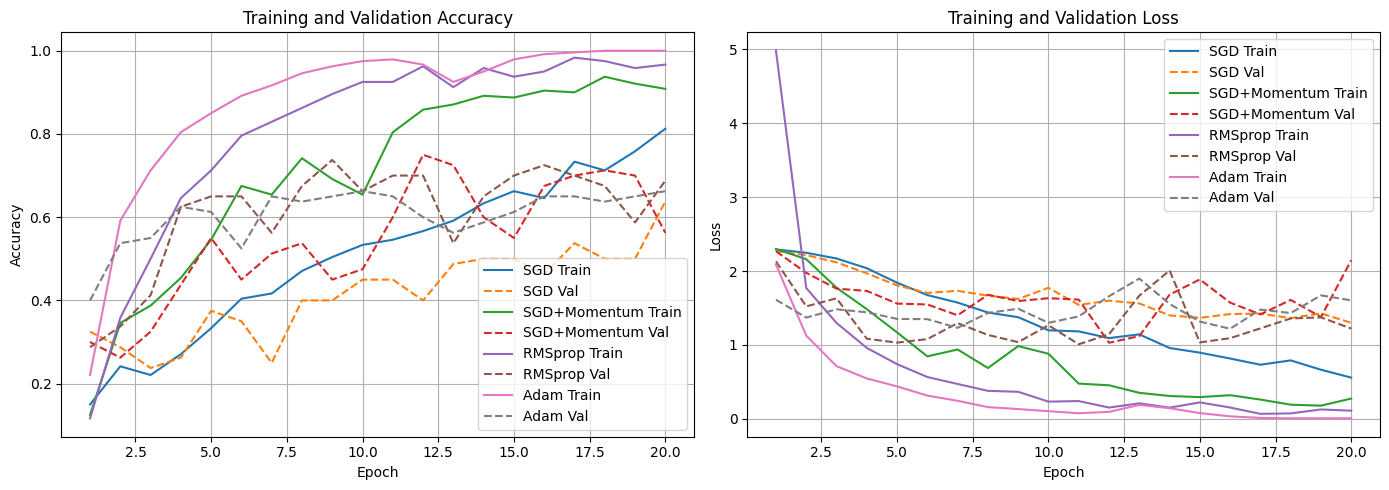

In [41]:
results = []
for opt in ['SGD', 'SGD+Momentum', 'RMSprop', 'Adam']:
    result = run_training(opt, ESC10CNN, train_loader, val_loader, test_loader, device)
    results.append(result)
plot_all_results(results)


In [42]:

for res in results:
    print(f"{res['optimizer']} Test Accuracy: {res['test_acc']:.4f}")


SGD Test Accuracy: 0.5500
SGD+Momentum Test Accuracy: 0.5875
RMSprop Test Accuracy: 0.7250
Adam Test Accuracy: 0.6125


# Norm comparison (3b)

In [126]:
norm_types = ['none', 'layer', 'batch']
all_losses = {}

for norm in norm_types:
    print(f"\n==== Training model with {norm} normalization ====\n")
    
    model = ESC10CNN(norm_type=norm).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=20,
        device=device,
        save_path=f"model_{norm}.pth"
    )
    
    all_losses[norm] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_acc': val_accs
    }



==== Training model with none normalization ====



Epoch 1/20 | Train Acc: 0.1833, Loss: 2.1832 | Val Acc: 0.4500, Loss: 1.7948


Epoch 2/20 | Train Acc: 0.5458, Loss: 1.3471 | Val Acc: 0.4125, Loss: 1.5984


Epoch 3/20 | Train Acc: 0.6542, Loss: 0.8617 | Val Acc: 0.6750, Loss: 1.2776


Epoch 4/20 | Train Acc: 0.8333, Loss: 0.5392 | Val Acc: 0.5375, Loss: 1.7120


Epoch 5/20 | Train Acc: 0.8250, Loss: 0.4818 | Val Acc: 0.6125, Loss: 1.4668


Epoch 6/20 | Train Acc: 0.8583, Loss: 0.4345 | Val Acc: 0.6250, Loss: 1.3778


Epoch 7/20 | Train Acc: 0.8792, Loss: 0.3795 | Val Acc: 0.6500, Loss: 1.2760


Epoch 8/20 | Train Acc: 0.9125, Loss: 0.2495 | Val Acc: 0.5750, Loss: 1.4756


Epoch 9/20 | Train Acc: 0.9583, Loss: 0.1729 | Val Acc: 0.7125, Loss: 1.3694


Epoch 10/20 | Train Acc: 0.9625, Loss: 0.1371 | Val Acc: 0.6375, Loss: 1.4187


Epoch 11/20 | Train Acc: 0.9583, Loss: 0.1582 | Val Acc: 0.6000, Loss: 1.7635


Epoch 12/20 | Train Acc: 0.9333, Loss: 0.1628 | Val Acc: 0.7500, Loss: 1.1743


Epoch 13/20 | Train Acc: 0.9833, Loss: 0.0744 | Val Acc: 0.6375, Loss: 1.3189


Epoch 14/20 | Train Acc: 0.9792, Loss: 0.0848 | Val Acc: 0.7250, Loss: 1.2303


Epoch 15/20 | Train Acc: 0.9958, Loss: 0.0345 | Val Acc: 0.7125, Loss: 1.4171


Epoch 16/20 | Train Acc: 0.9917, Loss: 0.0353 | Val Acc: 0.7125, Loss: 1.4283


Epoch 17/20 | Train Acc: 0.9958, Loss: 0.0307 | Val Acc: 0.7250, Loss: 1.4031


Epoch 18/20 | Train Acc: 1.0000, Loss: 0.0133 | Val Acc: 0.7375, Loss: 1.3561


Epoch 19/20 | Train Acc: 1.0000, Loss: 0.0098 | Val Acc: 0.7375, Loss: 1.5835


Epoch 20/20 | Train Acc: 0.9958, Loss: 0.0222 | Val Acc: 0.7500, Loss: 1.4198

==== Training model with layer normalization ====



Epoch 1/20 | Train Acc: 0.2917, Loss: 2.2133 | Val Acc: 0.3750, Loss: 1.8988


Epoch 2/20 | Train Acc: 0.6208, Loss: 1.1281 | Val Acc: 0.5500, Loss: 1.2451


Epoch 3/20 | Train Acc: 0.7792, Loss: 0.6288 | Val Acc: 0.5250, Loss: 1.3481


Epoch 4/20 | Train Acc: 0.8417, Loss: 0.4551 | Val Acc: 0.5875, Loss: 1.2504


Epoch 5/20 | Train Acc: 0.9042, Loss: 0.3124 | Val Acc: 0.6125, Loss: 1.3433


Epoch 6/20 | Train Acc: 0.9208, Loss: 0.2400 | Val Acc: 0.6375, Loss: 1.3468


Epoch 7/20 | Train Acc: 0.9375, Loss: 0.1720 | Val Acc: 0.6125, Loss: 1.3077


Epoch 8/20 | Train Acc: 0.9375, Loss: 0.1836 | Val Acc: 0.6875, Loss: 1.3601


Epoch 9/20 | Train Acc: 0.9542, Loss: 0.1412 | Val Acc: 0.6500, Loss: 1.2589


Epoch 10/20 | Train Acc: 0.9750, Loss: 0.0793 | Val Acc: 0.6875, Loss: 1.4639


Epoch 11/20 | Train Acc: 0.9542, Loss: 0.1263 | Val Acc: 0.7250, Loss: 1.2085


Epoch 12/20 | Train Acc: 0.9625, Loss: 0.0785 | Val Acc: 0.6375, Loss: 1.4044


Epoch 13/20 | Train Acc: 0.9833, Loss: 0.0574 | Val Acc: 0.6750, Loss: 1.2956


Epoch 14/20 | Train Acc: 0.9833, Loss: 0.0569 | Val Acc: 0.6500, Loss: 1.5254


Epoch 15/20 | Train Acc: 0.9958, Loss: 0.0198 | Val Acc: 0.7375, Loss: 1.2717


Epoch 16/20 | Train Acc: 0.9875, Loss: 0.0338 | Val Acc: 0.7500, Loss: 1.1554


Epoch 17/20 | Train Acc: 0.9958, Loss: 0.0121 | Val Acc: 0.7250, Loss: 1.1752


Epoch 18/20 | Train Acc: 0.9958, Loss: 0.0293 | Val Acc: 0.6375, Loss: 1.4555


Epoch 19/20 | Train Acc: 0.9958, Loss: 0.0222 | Val Acc: 0.6750, Loss: 1.3619


Epoch 20/20 | Train Acc: 0.9958, Loss: 0.0149 | Val Acc: 0.6875, Loss: 1.6298

==== Training model with batch normalization ====



Epoch 1/20 | Train Acc: 0.4042, Loss: 1.7598 | Val Acc: 0.4500, Loss: 1.6601


Epoch 2/20 | Train Acc: 0.7917, Loss: 0.6400 | Val Acc: 0.6375, Loss: 1.1892


Epoch 3/20 | Train Acc: 0.9083, Loss: 0.3115 | Val Acc: 0.5625, Loss: 1.4790


Epoch 4/20 | Train Acc: 0.9125, Loss: 0.2980 | Val Acc: 0.6250, Loss: 1.5859


Epoch 5/20 | Train Acc: 0.9542, Loss: 0.1527 | Val Acc: 0.6375, Loss: 1.6796


Epoch 6/20 | Train Acc: 0.9750, Loss: 0.0988 | Val Acc: 0.6375, Loss: 1.6239


Epoch 7/20 | Train Acc: 0.9750, Loss: 0.0589 | Val Acc: 0.6000, Loss: 2.0308


Epoch 8/20 | Train Acc: 0.9917, Loss: 0.0354 | Val Acc: 0.6375, Loss: 1.9594


Epoch 9/20 | Train Acc: 0.9958, Loss: 0.0258 | Val Acc: 0.5250, Loss: 2.4261


Epoch 10/20 | Train Acc: 0.9667, Loss: 0.0865 | Val Acc: 0.6250, Loss: 1.8421


Epoch 11/20 | Train Acc: 0.9833, Loss: 0.0461 | Val Acc: 0.6125, Loss: 1.7972


Epoch 12/20 | Train Acc: 0.9833, Loss: 0.0698 | Val Acc: 0.5500, Loss: 2.1104


Epoch 13/20 | Train Acc: 0.9958, Loss: 0.0233 | Val Acc: 0.6250, Loss: 1.8566


Epoch 14/20 | Train Acc: 0.9875, Loss: 0.0311 | Val Acc: 0.6750, Loss: 1.8285


Epoch 15/20 | Train Acc: 0.9875, Loss: 0.0282 | Val Acc: 0.6250, Loss: 2.0634


Epoch 16/20 | Train Acc: 0.9958, Loss: 0.0190 | Val Acc: 0.7125, Loss: 1.6750


Epoch 17/20 | Train Acc: 1.0000, Loss: 0.0070 | Val Acc: 0.7125, Loss: 1.7993


Epoch 18/20 | Train Acc: 1.0000, Loss: 0.0046 | Val Acc: 0.6625, Loss: 1.8731


Epoch 19/20 | Train Acc: 0.9958, Loss: 0.0217 | Val Acc: 0.5875, Loss: 2.2318


Epoch 20/20 | Train Acc: 0.9917, Loss: 0.0462 | Val Acc: 0.5875, Loss: 2.1076


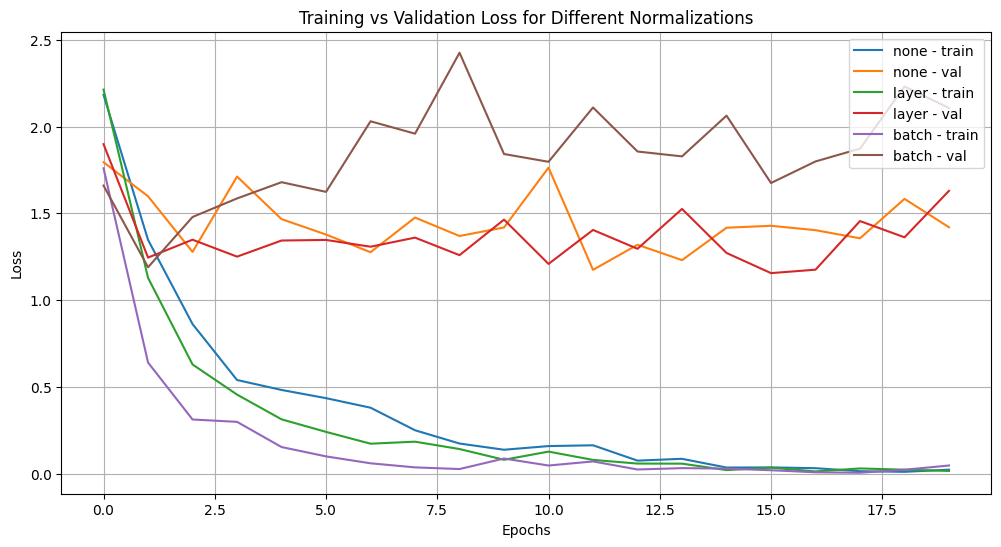

In [127]:
import matplotlib.pyplot as plt

def plot_losses(all_losses):
    plt.figure(figsize=(12, 6))
    for norm, losses in all_losses.items():
        plt.plot(losses['train_loss'], label=f"{norm} - train")
        plt.plot(losses['val_loss'], label=f"{norm} - val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss for Different Normalizations")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(all_losses)


In [128]:
for norm in norm_types:
    model = ESC10CNN(norm_type=norm).to(device)
    model.load_state_dict(torch.load(f"model_{norm}.pth"))
    print(f"Test accuracy for {norm} normalization:")
    evaluate_model(model, test_loader)


/tmp/ipykernel_1341202/2185713222.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_{norm}.pth"))


Test accuracy for none normalization:
Test Accuracy: 0.7500
Test accuracy for layer normalization:
Test Accuracy: 0.7875
Test accuracy for batch normalization:
Test Accuracy: 0.6875


# Ensembling (Q3c)

In [112]:
configs = [
    {"name": "model_sgd", "optimizer": "sgd", "norm": "none"},
    {"name": "model_rmsprop", "optimizer": "rmsprop", "norm": "layer"},
    {"name": "model_adam", "optimizer": "adam", "norm": "batch"},
]

all_models = {}
val_outputs = []
val_labels = None


In [113]:
for config in configs:
    print(f"\nTraining {config['name']} with {config['optimizer']} and {config['norm']} norm\n")

    model = ESC10CNN(norm_type=config["norm"]).to(device)
    criterion = nn.CrossEntropyLoss()

    if config["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif config["optimizer"] == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    _, _, _, _ = train_model(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=20,
        device=device,
        save_path=f"{config['name']}.pth"
    )

    # Save model
    all_models[config["name"]] = ESC10CNN(norm_type=config["norm"]).to(device)
    all_models[config["name"]].load_state_dict(torch.load(f"{config['name']}.pth"))
    all_models[config["name"]].eval()

    # Collect outputs on validation set
    preds = []
    labels = []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            out = F.softmax(all_models[config["name"]](X), dim=1)
            preds.append(out.cpu())
            labels.append(y)
    val_outputs.append(torch.cat(preds, dim=0))
    val_labels = torch.cat(labels, dim=0)



Training model_sgd with sgd and none norm



Epoch 1/20 | Train Acc: 0.1417, Loss: 2.2921 | Val Acc: 0.2125, Loss: 2.2685


Epoch 2/20 | Train Acc: 0.2958, Loss: 2.2444 | Val Acc: 0.3500, Loss: 2.2149


Epoch 3/20 | Train Acc: 0.3792, Loss: 2.1693 | Val Acc: 0.3875, Loss: 2.1309


Epoch 4/20 | Train Acc: 0.4083, Loss: 2.0432 | Val Acc: 0.4250, Loss: 1.9846


Epoch 5/20 | Train Acc: 0.4417, Loss: 1.8385 | Val Acc: 0.5125, Loss: 1.7471


Epoch 6/20 | Train Acc: 0.4625, Loss: 1.5543 | Val Acc: 0.5000, Loss: 1.5406


Epoch 7/20 | Train Acc: 0.5542, Loss: 1.3066 | Val Acc: 0.4625, Loss: 1.4388


Epoch 8/20 | Train Acc: 0.6125, Loss: 1.1098 | Val Acc: 0.4750, Loss: 1.2994


Epoch 9/20 | Train Acc: 0.5583, Loss: 1.2050 | Val Acc: 0.5375, Loss: 1.2570


Epoch 10/20 | Train Acc: 0.6750, Loss: 0.9146 | Val Acc: 0.5375, Loss: 1.2962


Epoch 11/20 | Train Acc: 0.7333, Loss: 0.8045 | Val Acc: 0.5000, Loss: 1.3511


Epoch 12/20 | Train Acc: 0.6708, Loss: 0.8794 | Val Acc: 0.5875, Loss: 1.2167


Epoch 13/20 | Train Acc: 0.7542, Loss: 0.6748 | Val Acc: 0.5000, Loss: 1.4049


Epoch 14/20 | Train Acc: 0.7625, Loss: 0.6488 | Val Acc: 0.5750, Loss: 1.2100


Epoch 15/20 | Train Acc: 0.7792, Loss: 0.5899 | Val Acc: 0.5750, Loss: 1.3103


Epoch 16/20 | Train Acc: 0.7958, Loss: 0.6382 | Val Acc: 0.5000, Loss: 1.3263


Epoch 17/20 | Train Acc: 0.8500, Loss: 0.4772 | Val Acc: 0.6000, Loss: 1.1983


Epoch 18/20 | Train Acc: 0.8375, Loss: 0.4543 | Val Acc: 0.6000, Loss: 1.2934


Epoch 19/20 | Train Acc: 0.8542, Loss: 0.4701 | Val Acc: 0.5625, Loss: 1.3819


/tmp/ipykernel_1341202/1387295052.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_models[config["name"]].load_state_dict(torch.load(f"{config['name']}.pth"))


Epoch 20/20 | Train Acc: 0.8542, Loss: 0.4807 | Val Acc: 0.5375, Loss: 1.4408

Training model_rmsprop with rmsprop and layer norm



Epoch 1/20 | Train Acc: 0.1458, Loss: 21.6656 | Val Acc: 0.1375, Loss: 2.6531


Epoch 2/20 | Train Acc: 0.2958, Loss: 1.9472 | Val Acc: 0.3375, Loss: 1.8416


Epoch 3/20 | Train Acc: 0.3833, Loss: 1.6241 | Val Acc: 0.3500, Loss: 1.7607


Epoch 4/20 | Train Acc: 0.4625, Loss: 1.3757 | Val Acc: 0.4375, Loss: 1.6849


Epoch 5/20 | Train Acc: 0.5292, Loss: 1.2131 | Val Acc: 0.4250, Loss: 1.7274


Epoch 6/20 | Train Acc: 0.5583, Loss: 1.1438 | Val Acc: 0.4250, Loss: 1.6844


Epoch 7/20 | Train Acc: 0.5500, Loss: 1.1520 | Val Acc: 0.5000, Loss: 1.7381


Epoch 8/20 | Train Acc: 0.7083, Loss: 0.8183 | Val Acc: 0.4625, Loss: 1.6791


Epoch 9/20 | Train Acc: 0.7167, Loss: 0.7333 | Val Acc: 0.5375, Loss: 1.5050


Epoch 10/20 | Train Acc: 0.7417, Loss: 0.6992 | Val Acc: 0.5250, Loss: 1.7511


Epoch 11/20 | Train Acc: 0.7083, Loss: 0.7918 | Val Acc: 0.5250, Loss: 1.6017


Epoch 12/20 | Train Acc: 0.8250, Loss: 0.5420 | Val Acc: 0.5875, Loss: 1.5831


Epoch 13/20 | Train Acc: 0.7917, Loss: 0.6052 | Val Acc: 0.5250, Loss: 1.7895


Epoch 14/20 | Train Acc: 0.8333, Loss: 0.4920 | Val Acc: 0.5125, Loss: 2.1318


Epoch 15/20 | Train Acc: 0.7333, Loss: 0.6145 | Val Acc: 0.4750, Loss: 2.1045


Epoch 16/20 | Train Acc: 0.8125, Loss: 0.5112 | Val Acc: 0.5250, Loss: 1.7621


Epoch 17/20 | Train Acc: 0.9042, Loss: 0.3104 | Val Acc: 0.5250, Loss: 1.9761


Epoch 18/20 | Train Acc: 0.8417, Loss: 0.3788 | Val Acc: 0.5000, Loss: 1.7330


Epoch 19/20 | Train Acc: 0.8708, Loss: 0.3872 | Val Acc: 0.5250, Loss: 1.9649


Epoch 20/20 | Train Acc: 0.8917, Loss: 0.3230 | Val Acc: 0.5375, Loss: 1.9356

Training model_adam with adam and batch norm



Epoch 1/20 | Train Acc: 0.4875, Loss: 1.5332 | Val Acc: 0.4375, Loss: 1.4631


Epoch 2/20 | Train Acc: 0.8333, Loss: 0.5214 | Val Acc: 0.5625, Loss: 1.2622


Epoch 3/20 | Train Acc: 0.9125, Loss: 0.3415 | Val Acc: 0.6000, Loss: 1.4536


Epoch 4/20 | Train Acc: 0.9542, Loss: 0.1306 | Val Acc: 0.7000, Loss: 1.3987


Epoch 5/20 | Train Acc: 0.9500, Loss: 0.1254 | Val Acc: 0.6500, Loss: 1.5153


Epoch 6/20 | Train Acc: 0.9667, Loss: 0.1094 | Val Acc: 0.6500, Loss: 1.5332


Epoch 7/20 | Train Acc: 0.9750, Loss: 0.0988 | Val Acc: 0.6875, Loss: 1.2781


Epoch 8/20 | Train Acc: 0.9958, Loss: 0.0235 | Val Acc: 0.6875, Loss: 1.3300


Epoch 9/20 | Train Acc: 1.0000, Loss: 0.0067 | Val Acc: 0.7000, Loss: 1.3850


Epoch 10/20 | Train Acc: 0.9958, Loss: 0.0133 | Val Acc: 0.6750, Loss: 1.5519


Epoch 11/20 | Train Acc: 0.9958, Loss: 0.0196 | Val Acc: 0.7500, Loss: 1.3911


Epoch 12/20 | Train Acc: 0.9958, Loss: 0.0297 | Val Acc: 0.7000, Loss: 1.6136


Epoch 13/20 | Train Acc: 0.9875, Loss: 0.0547 | Val Acc: 0.6625, Loss: 1.8144


Epoch 14/20 | Train Acc: 0.9750, Loss: 0.0630 | Val Acc: 0.6500, Loss: 1.7336


Epoch 15/20 | Train Acc: 0.9875, Loss: 0.0345 | Val Acc: 0.6750, Loss: 1.6124


Epoch 16/20 | Train Acc: 0.9875, Loss: 0.0445 | Val Acc: 0.6500, Loss: 1.9209


Epoch 17/20 | Train Acc: 0.9792, Loss: 0.0944 | Val Acc: 0.6125, Loss: 1.4880


Epoch 18/20 | Train Acc: 0.9917, Loss: 0.0280 | Val Acc: 0.6000, Loss: 1.8682


Epoch 19/20 | Train Acc: 0.9875, Loss: 0.0223 | Val Acc: 0.6375, Loss: 1.9243


Epoch 20/20 | Train Acc: 0.9875, Loss: 0.0323 | Val Acc: 0.7375, Loss: 1.7117


In [ ]:
avg_val_output = sum(val_outputs) / len(val_outputs)
avg_preds = torch.argmax(avg_val_output, dim=1)
acc_avg = (avg_preds == val_labels).float().mean().item()
print(f"\n Ensemble Accuracy (Output Averaging): {acc_avg * 100:.2f}%")
val_stack = torch.stack(val_outputs, dim=1)
num_classes = 10
val_onehot = F.one_hot(val_labels, num_classes).float()

X_val = val_stack.permute(0, 2, 1).reshape(-1, 3)
y_val = val_onehot.reshape(-1)
res = torch.linalg.lstsq(X_val, y_val.unsqueeze(1))
weights = res.solution[:3].squeeze()
weights = weights / weights.sum()  # normalize to sum to 1


print(f"\n Optimal weights: {weights.tolist()}")

# Weighted combination
weighted_output = weights[0]*val_outputs[0] + weights[1]*val_outputs[1] + weights[2]*val_outputs[2]
weighted_preds = torch.argmax(weighted_output, dim=1)
acc_weighted = (weighted_preds == val_labels).float().mean().item()
print(f"\n Ensemble Accuracy (Weighted Linear Combo): {acc_weighted * 100:.2f}%")



 Ensemble Accuracy (Output Averaging): 70.00%

 Optimal weights: [0.26886406540870667, -0.029929552227258682, 0.7610655426979065]

 Ensemble Accuracy (Weighted Linear Combo): 75.00%


Ensembling improves the accuracy from around 68% to almost 70% and 75% respectively for averaging and weighted linear combination.

This is because ensembling reduces the variance of the model by combining predictions from multiple models, leading to a more robust and accurate final prediction. The weighted linear combination allows for more flexibility in adjusting the contribution of each model based on their performance, further enhancing the overall accuracy.